I have been given a file with data on flight searches from Boston to Cancun by Hopper. This analysis is meant to answer the question of how much a customer should expect to pay for a return trip from Boston to Cancun based on these data and to produce a customer-oriented article.

Metadata:
fields: 
- messageid : { type: string, comment: 'Unique ID for trip bundle'}
- tripindex : { type: integer, comment: 'Within-bundle trip count, from 0'}
- received : { type: date, format: epoch-seconds }
- currency : { type: string, tags: [categorical], comment: 'Convert prices via currency xref' }
- total : { type: real }
- tax : { type: real }
- surcharge : { type: real }
- source : { type: string, tags: [categorical] }
- merchant : { type: string, tags: [categorical], comment: 'Ticketing authority' }
- majorcarrierid: {type: string, tags: [categorical], comment: 'Ticketing airline' }
- origin : { type: string, tags: [categorical], comment: 'Three letter IATA airport code' }
- destination : { type: string, tags: [categorical], comment: 'Three letter IATA airport code' }
- departure : { type: date, format: epoch-seconds, comment: 'UTC time of departure (convert to origin TZ to get local departure time)' }
- return : { type: date, format: epoch-seconds, comment: 'UTC time of departure (convert to destination TZ to get local return time)' }
- los2 : { type: integer, comment: 'Difference between yyyymmdd of departure in local time at origin and yyyymmdd of return in local time at destination.' }
- outbounddurationminutes : { type: integer }
- outboundstops : { type : integer }
- returndurationminutes : { type : integer }
- returnstops : { type : integer }
- availableseats : { type : integer }
- cabinclass : { type: string, tags: [categorical], values: [E, B, F], comment: 'Economy, business or first class' }
- paxtype : { type: string, tags: [categorical] }
- refundable : { type: boolean, comment: 'Indicates refundable ticket' }
- triptimestamp : { type: date, format: epoch-seconds, comment: 'When this query result was generated (UTC)' }
- receiveddate : { type: date, format: yyyymmdd, comment: 'Day message received at Hopper. Hive table is partitioned on this value' }

Exploratory Data Analysis

In [1]:
# Importing the usual modules.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# The data file is read.
flights = pd.read_csv("BOS_CUN_trips1M.csv",)
flights.head()

,messageid,tripindex,received,currency,total,tax,surcharge,source,merchant,majorcarrierid,...,refundable,triptimestamp,receiveddate,received_odate,departure_odate,return_ddate,los2,departure_dow,return_dow,includes_sns
0,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,12,1382317607,USD,631.45,123.45,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
1,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,11,1382317607,USD,632.95,124.95,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
2,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,10,1382317607,USD,620.95,124.95,0.0,Sabre,TCY,B6,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
3,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,9,1382317607,USD,632.95,124.95,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
4,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,8,1382317607,USD,565.95,124.95,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1


In [3]:
# Displaying DataFrame columns.
flights.columns

Index([u'messageid', u'tripindex', u'received', u'currency', u'total', u'tax',
       u'surcharge', u'source', u'merchant', u'majorcarrierid', u'origin',
       u'destination', u'departure', u'return', u'outbounddurationminutes',
       u'outboundstops', u'returndurationminutes', u'returnstops',
       u'availableseats', u'cabinclass', u'paxtype', u'refundable',
       u'triptimestamp', u'receiveddate', u'received_odate',
       u'departure_odate', u'return_ddate', u'los2', u'departure_dow',
       u'return_dow', u'includes_sns'],
      dtype='object')

In [4]:
# Some basic information about each column in the flights DataFrame 
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202445 entries, 0 to 1202444
Data columns (total 31 columns):
messageid                  1202445 non-null object
tripindex                  1202445 non-null int64
received                   1202445 non-null int64
currency                   1202445 non-null object
total                      1202445 non-null float64
tax                        1202445 non-null float64
surcharge                  1202445 non-null float64
source                     1202445 non-null object
merchant                   1202445 non-null object
majorcarrierid             1202445 non-null object
origin                     1202445 non-null object
destination                1202445 non-null object
departure                  1202445 non-null int64
return                     1202445 non-null int64
outbounddurationminutes    1202445 non-null int64
outboundstops              1202445 non-null int64
returndurationminutes      1202445 non-null int64
returnstops             

Part 1: Flight prices variation.

This analysis will include exploring the dataset and doing basic analysis on the flight prices, without looking at the different factors that could impact it.

Throughout this analysis, I assume that the total flight prices include tax.

I choose to use averages as they are easily understandable by the customer.

/Users/katarzynarachuta/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:2125: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


'I noticed one very obvious outlier at ~$6,500\n75%  of the tickets are under around ~$1250'

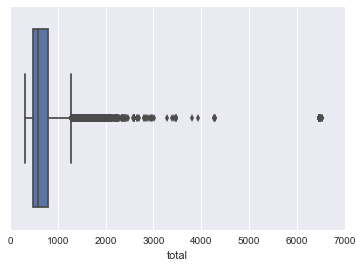

In [5]:
'''Below is a quick visualisation of the data using a box plot. This helps to see how the data are spread out.'''

sns.boxplot(flights['total'], vert=False)

'''There is one very obvious outlier at ~$6,500.
75%  of the tickets are under around ~$1250'''

(array([  3.69275000e+05,   4.02028000e+05,   1.76229000e+05,
          1.10833000e+05,   6.60720000e+04,   4.90930000e+04,
          1.95260000e+04,   7.10100000e+03,   1.57200000e+03,
          3.33000000e+02,   2.05000000e+02,   1.80000000e+01,
          9.00000000e+00,   4.00000000e+00,   9.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   6.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   4.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.24000000e+02]),
 array([  320.37      ,   497.60914286,   674.84828571,   852.08742857,
         1029.32657143,  1206.56571429,  1383.80485714,  1561.044     ,
         1738.28314286,  1915.52228571,  2092.76142857,  2270.00057143,
         2447.23971429,  2624.47885714,  2801.718     , 

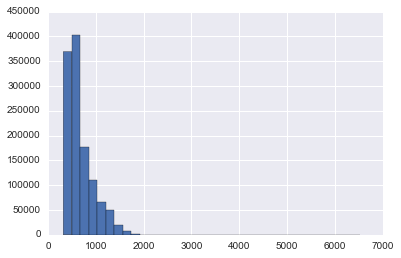

In [6]:
'''One last viualisation is a histogram. The optimum number of bins is 35 as it produces a clear picture.'''
plt.hist(flights['total'], bins=35)

(array([  1.70000000e+03,   3.43490000e+04,   1.08253000e+05,
          1.03648000e+05,   9.39940000e+04,   9.47580000e+04,
          8.23930000e+04,   7.78260000e+04,   7.75220000e+04,
          6.76010000e+04,   4.94840000e+04,   4.35420000e+04,
          2.95500000e+04,   3.42650000e+04,   2.70490000e+04,
          2.36180000e+04,   2.75910000e+04,   2.76190000e+04,
          1.92230000e+04,   1.86750000e+04,   1.47200000e+04,
          1.04230000e+04,   1.30620000e+04,   1.26590000e+04,
          1.54020000e+04,   1.13250000e+04,   1.06140000e+04,
          1.39430000e+04,   1.09710000e+04,   6.61300000e+03,
          7.38300000e+03,   5.17300000e+03,   3.49000000e+03,
          4.71100000e+03,   3.58600000e+03,   3.65500000e+03,
          2.67100000e+03,   1.91600000e+03,   9.98000000e+02,
          1.19400000e+03,   1.54600000e+03,   1.36900000e+03,
          3.87000000e+02,   6.13000000e+02,   2.76000000e+02,
          1.68000000e+02,   9.90000000e+01,   1.61000000e+02,
        

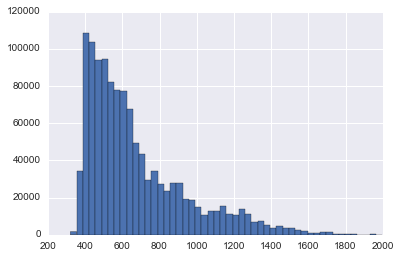

In [7]:
'''Below is a visualisation of the data for prices below $2,000. This allows to better view the distribution around
those lower values as from the above histogram, it seems obvious that a lot of lower-priced flights are below
that price.'''

flights2 = flights[flights['total'] < 2000]

plt.hist(flights2['total'], bins=50)

In [8]:
'''Below are the actual figures for the mean and quartiles.'''

flights_price = flights['total']
flights_price = pd.DataFrame(flights_price)
flights_price.describe()

,total
count,1.202445e+06
mean,6.742877e+02
std,2.787050e+02
min,3.203700e+02
25%,4.719500e+02
50%,5.913700e+02
75%,7.933700e+02
max,6.523740e+03


This means that the mean price is ~$674, we will pay the minimum of $320. 
50% of the flights cost $591 or less and 75% of the flights cost $793 or less.
The most expensive flight was at $6523.74
the cabin class - I would expect the flights to be expensive for first class and cheapest for the economy class
the number of stopovers - I expect direct flights to be most expensive
refundable/non-refundable tickets - I would expect the latter to be cheaper
airline - some airlines will be more expensive than others
date booked - booking really far ahead and really close to the departure date should be expensive
travel time - some times will be cheaper than others
day of the week when we searched for the prices - usually it is recommended that you book a flight on a Tuesday and
avoid booking on a Friday.
I will now test these hypotheses.

Part 2: Flight prices by cabin class

The below analysis looks at the different cabin classes: economy, business and first class.

In [9]:
# Economy class
economy = flights[flights['cabinclass'] == 'E']
economy.head()
# 1201004 records

,messageid,tripindex,received,currency,total,tax,surcharge,source,merchant,majorcarrierid,...,refundable,triptimestamp,receiveddate,received_odate,departure_odate,return_ddate,los2,departure_dow,return_dow,includes_sns
0,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,12,1382317607,USD,631.45,123.45,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
1,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,11,1382317607,USD,632.95,124.95,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
2,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,10,1382317607,USD,620.95,124.95,0.0,Sabre,TCY,B6,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
3,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,9,1382317607,USD,632.95,124.95,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
4,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,8,1382317607,USD,565.95,124.95,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1


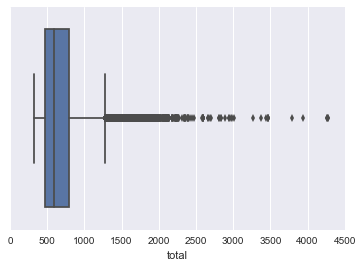

In [10]:
# Visualisation of the economy flights.
sns.boxplot(economy['total'], vert=False)

In [11]:
'''From the box plot above, it can be seen how the data are spread out. The exact numbers
for the mean, the quartiles and standard deviation are below.'''

economytotal = economy['total'].describe()
economytotal = pd.DataFrame(economytotal)
economytotal
'''For an economy flight, a customer won't pay more than ~$4278, with the mean value being $674 
and median being $591.
The standard deviation is high at $272 (its almost half the mean).'''

,total
count,1.201004e+06
mean,6.735797e+02
std,2.724485e+02
min,3.203700e+02
25%,4.719500e+02
50%,5.909500e+02
75%,7.933700e+02
max,4.278770e+03


In [12]:
# Bsiness class flights
business = flights[flights['cabinclass'] == 'B']
business.head()
# 1041 records - much less than for the economy flights.

,messageid,tripindex,received,currency,total,tax,surcharge,source,merchant,majorcarrierid,...,refundable,triptimestamp,receiveddate,received_odate,departure_odate,return_ddate,los2,departure_dow,return_dow,includes_sns
20173,11d548da24b2a342000001414e7f330828c6951ee8d33c5a,424,1380001461,USD,599.27,119.27,0.0,Amadeus,FL,FL,...,False,1380001461,20130924,2013-09-23,2013-11-23,2013-11-25,2,6,1,1
20174,11d548da24b2a342000001414e7f330828c6951ee8d33c5a,425,1380001461,USD,599.27,119.27,0.0,Amadeus,FL,FL,...,False,1380001461,20130924,2013-09-23,2013-11-23,2013-11-28,5,6,4,1
23629,3248dfa1a07f76fe000001416dce75480166920c4c89ca56,988,1380526749,USD,1240.37,101.37,0.0,Amadeus,UA,UA,...,False,1380526749,20130930,2013-09-29,2013-11-16,2013-12-01,15,6,0,1
23631,3248dfa1a07f76fe000001416dce75480166920c4c89ca56,986,1380526749,USD,1081.37,101.37,0.0,Amadeus,UA,UA,...,False,1380526749,20130930,2013-09-29,2013-11-17,2013-11-30,13,0,6,1
23635,3248dfa1a07f76fe000001416dce75480166920c4c89ca56,982,1380526749,USD,975.37,101.37,0.0,Amadeus,UA,UA,...,False,1380526749,20130930,2013-09-29,2013-11-15,2013-11-30,15,5,6,1


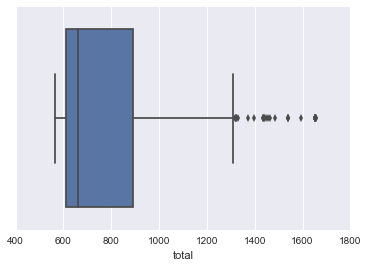

In [13]:
# Box plot visualisating the data.
sns.boxplot(business['total'], vert=False)

In [14]:
'''For the business class tickets, there is a relatively big difference between the median and the third quartile.'''

businesstotal = business['total'].describe()
businesstotal = pd.DataFrame(businesstotal)
businesstotal

,total
count,1041.000000
mean,786.415043
std,245.655838
min,562.570000
25%,608.850000
50%,659.180000
75%,892.170000
max,1657.950000


For a business flight, the mean flight price is $786 and the median is $659
and a customer should not expect to pay more than $1658.
Again, the standard deviation is quite high at $245.
The maximum price is $1658 which my seem relatively low.

In [15]:
# First class flights

first = flights[flights['cabinclass'] == 'F']
first.head()
# 276 records.

,messageid,tripindex,received,currency,total,tax,surcharge,source,merchant,majorcarrierid,...,refundable,triptimestamp,receiveddate,received_odate,departure_odate,return_ddate,los2,departure_dow,return_dow,includes_sns
21108,11d548da24b2a342000001414e7f330828c6951ee8d33c5a,1076,1380001461,USD,703.37,115.37,0.0,Amadeus,AA,AA,...,False,1380001461,20130924,2013-09-23,2013-10-11,2013-10-21,10,5,1,1
21109,11d548da24b2a342000001414e7f330828c6951ee8d33c5a,1077,1380001461,USD,703.37,115.37,0.0,Amadeus,AA,AA,...,False,1380001461,20130924,2013-09-23,2013-10-11,2013-10-26,15,5,6,1
21130,11d548da24b2a342000001414e7f330828c6951ee8d33c5a,1098,1380001461,USD,683.37,115.37,0.0,Amadeus,AA,AA,...,False,1380001461,20130924,2013-09-23,2013-10-11,2013-10-18,7,5,5,1
21131,11d548da24b2a342000001414e7f330828c6951ee8d33c5a,1099,1380001461,USD,703.37,115.37,0.0,Amadeus,AA,AA,...,False,1380001461,20130924,2013-09-23,2013-10-11,2013-10-19,8,5,6,1
23564,3248dfa1a07f76fe000001416dce75480166920c4c89ca56,1053,1380526749,USD,629.37,115.37,0.0,Amadeus,DL,DL,...,False,1380526749,20130930,2013-09-29,2013-11-14,2013-11-29,15,4,5,1


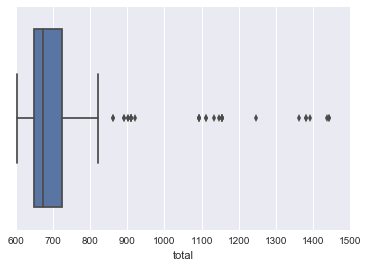

In [16]:
# Box plot visualisating the data.
sns.boxplot(first['total'], vert=False)

In [17]:
'''The distribution is much less spread out than that for the business class tickets. Below are the mean,
quartiles, standard deviation etc.'''

firsttotal = first['total'].describe()
firsttotal = pd.DataFrame(firsttotal)
firsttotal

,total
count,276.000000
mean,726.727464
std,161.349212
min,604.370000
25%,648.950000
50%,673.370000
75%,725.950000
max,1441.370000


On average, a customer should expect to pay $726, with the median being $673.
I shouldnt pay more than $1441 per flight. Standard deviation is lowest at only $161 - which
means that my observation that the data is the least spread out compared to other tickets is true

In [18]:
'''There is also a fourth class in the cabinclass column and its called EP.
This is excluded from this analysis.'''

flights2 = flights[flights['cabinclass'] != 'EP']

It is difficult to compare the prices for the three different cabin classes without visualising them in one place. Below there is a visualisation of three box plots that allows for comparison.

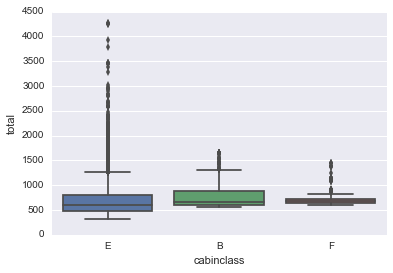

In [20]:
sns.boxplot(flights2['cabinclass'], flights2['total'])

As expected, I can see the economy prices start at lowest values. But they are also really spread - especially
all of the prices above the third quartile. In comparison, first class tickets are very 'condensed'.
Again, please note that I used the total price and I am not sure if it includes tax.

Part 3: Flight price variety by airline

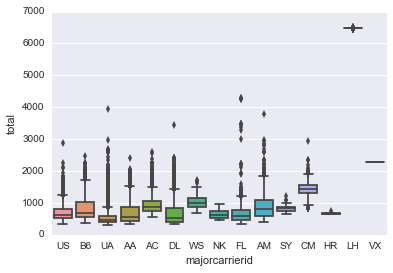

In [21]:
# Boxplot visualisation.

sns.boxplot(flights['majorcarrierid'], flights['total'])

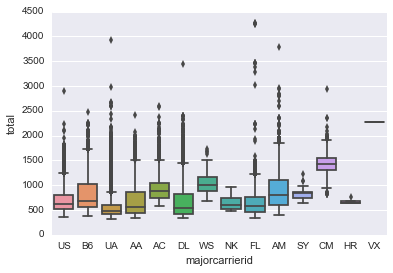

In [24]:
'''There is something odd happening with LH. This will be excluded as an outlier.
UA (United) Airlines are on the cheaper side (but has a lot of outliers).
HR (Hahn Air) has a very narrow spread of the price differences. 
'''
airlines = flights[flights['majorcarrierid'] != 'LH']
sns.boxplot(airlines['majorcarrierid'], airlines['total'])

In [25]:
'''The second visualisation is much clearer. HR has a very small distribution of flight prices,
and so does VX where the flight prices are very narrow.
Below are mean prices by the airline.'''
meanprice = flights.groupby('majorcarrierid').mean()
meanpricedf = pd.DataFrame(meanprice['total'])
meanpricedf.sort_values(by='total')

,total
majorcarrierid,
UA,540.865941
FL,626.696252
NK,651.178757
DL,664.189529
HR,673.265000
AA,687.301207
US,692.882309
B6,801.564038
SY,817.057615


We can now see how these prices are different. For example, the cheapest major carrier on average is UA,
the most expensive carrier by the average price is LH, which is Lufthansa.

Part 4: Price variation for refundable and non-refundable flights.

In [26]:
# First, the refundable flights are analysed.
refundableflights = flights[flights['refundable'] == True]
refundableflights.head()

,messageid,tripindex,received,currency,total,tax,surcharge,source,merchant,majorcarrierid,...,refundable,triptimestamp,receiveddate,received_odate,departure_odate,return_ddate,los2,departure_dow,return_dow,includes_sns
861,2c89c1ab745aec26000001410e399ab3aa9fe4728648ad8b,45,1378923158,USD,1251.57,116.57,0.0,Sabre,TCY,AM,...,True,1378923158,20130911,2013-09-11,2014-07-10,2014-07-18,8,4,5,1
947,3dc7cac49ef4382f000001410d1a5a260697a02b899615e0,37,1378904332,USD,930.57,116.57,0.0,Sabre,TCY,AM,...,True,1378904332,20130911,2013-09-11,2013-09-22,2013-09-29,7,0,0,1
1020,42e64275e7bb0edd000001410d102090ecb3e2ded758ba6f,17,1378903662,USD,930.57,116.57,0.0,Sabre,TCY,AM,...,True,1378903662,20130911,2013-09-11,2013-10-11,2013-10-19,8,5,6,1
1448,b54624dc6c91bc1e00000141e5685bb04257f803208eafb6,35,1382533323,USD,1495.15,112.15,0.0,Sabre,TCY,AM,...,True,1382533323,20131023,2013-10-23,2014-04-19,2014-04-26,7,6,6,1
1450,b54624dc6c91bc1e00000141e5685bb04257f803208eafb6,33,1382533323,USD,980.15,126.15,0.0,Sabre,TCY,AM,...,True,1382533323,20131023,2013-10-23,2014-04-19,2014-04-26,7,6,6,1


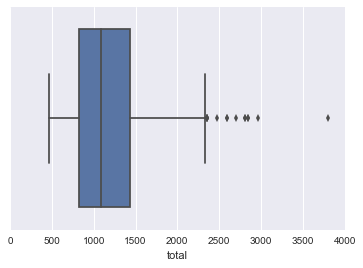

In [27]:
# Below is a box plot of the price spread of the refundable tickets.
sns.boxplot(refundableflights['total'], vert=False)
# I can see that 75% of the refundable tickets are below $2,4000.

In [28]:
# Below are some simple statistics the refundable ticket prices.

refundableflights = refundableflights['total'].describe()
refundableflights = pd.DataFrame(refundableflights)
refundableflights

,total
count,7924.000000
mean,1145.334387
std,408.931065
min,466.170000
25%,826.950000
50%,1089.150000
75%,1436.570000
max,3794.570000


In [29]:
# Below non-refundable flights are analysed.

nrefundableflights = flights[flights['refundable'] == False]
nrefundableflights.head()

,messageid,tripindex,received,currency,total,tax,surcharge,source,merchant,majorcarrierid,...,refundable,triptimestamp,receiveddate,received_odate,departure_odate,return_ddate,los2,departure_dow,return_dow,includes_sns
0,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,12,1382317607,USD,631.45,123.45,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
1,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,11,1382317607,USD,632.95,124.95,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
2,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,10,1382317607,USD,620.95,124.95,0.0,Sabre,TCY,B6,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
3,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,9,1382317607,USD,632.95,124.95,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
4,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,8,1382317607,USD,565.95,124.95,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1


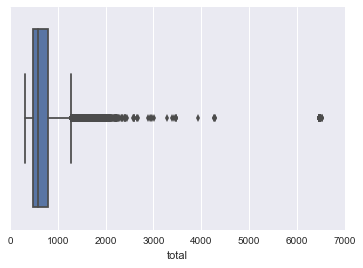

In [30]:
# Here is a box plot of the price spread of the non-refundable tickets.

sns.boxplot(nrefundableflights['total'], vert=False)
# I can see that 75% of the non-refundable flights are below $1,250.

In [31]:
# Below there are some basic statistics.
nrefundableflights = nrefundableflights['total'].describe()
nrefundableflights = pd.DataFrame(nrefundableflights)
nrefundableflights

,total
count,1.194521e+06
mean,6.711629e+02
std,2.749562e+02
min,3.203700e+02
25%,4.713700e+02
50%,5.893700e+02
75%,7.894500e+02
max,6.523740e+03


'As expect, the refundable flights are more expensive. However, I am surprised by the fact that the\nnon-refundable flights have quite a lot of expenisve outliers.'

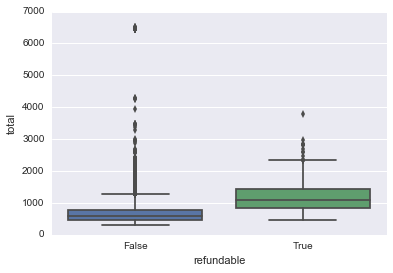

In [32]:
# Below one can see the boxplots for both refundable and non-refundable flights to allow for easy comparison.
sns.boxplot(flights['refundable'], flights['total'])

As expected, the refundable flights are more expensive. However, there are quite a lot of outliers for the non-refundable flights - especially one at $6,5000.

Part 5: Price variation with the number of stopovers
I will now look at the different number of stopovers and see how the prices are spread here.

In [33]:
# The flight prices are grouped by the number of outbound and return stops.
groupedflights = flights.groupby(['outboundstops', 'returnstops']).mean()
groupedflights = pd.DataFrame(groupedflights['total'])
groupedflights
# Again, I'm only interested in the 'total' column.

total
outboundstops returnstops            
0             0            956.847618
              1            826.761802
              2            775.938667
1             0            781.470335
              1            651.233799
              2            638.635024
              3            489.361429
2             0            758.911642
              1            635.264192
              2            611.120183
              3            470.450000
3             0            768.576612
              1            726.988780
              2            647.720327

In [34]:
# The table is pivoted below to allow for easy comparison for a consumer.
groupedflights.to_csv("number_of_stopovers.csv")
number_of_stopovers = pd.read_csv("number_of_stopovers.csv")
number_of_stopoverspiv = number_of_stopovers.pivot("outboundstops", "returnstops", "total")
number_of_stopoverspiv

returnstops,0,1,2,3
outboundstops,,,,
0,956.847618,826.761802,775.938667,NaN
1,781.470335,651.233799,638.635024,489.361429
2,758.911642,635.264192,611.120183,470.450000
3,768.576612,726.988780,647.720327,NaN


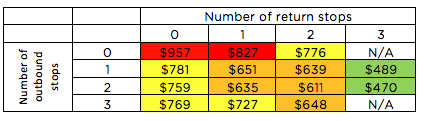

In [2]:
# Below, there is a colour-coded version for the customer.
Image("bookingday.png")

On average, a trip with both no outbound stops and no return stops is the most expensive.
This is not surprising. The cheapest flight combination is with 2 outbound stops 
and 3 return stops. It is not possible to fly with no outbound stops and 3 return stops, and it is not possible to have 3 stops on both legs of the journey.

Part 6: Price variation with the day of the week that travel was booked on

In [35]:
'''This analysis will only require four columns from the flights DataFrame: departure, return, triptimestamp (when the
journey was search for on) and total price.'''
dates = flights[['departure', 'return', 'triptimestamp', 'total']]
dates.head()

,departure,return,triptimestamp,total
0,1394789400,1395503700,1382317607,631.45
1,1394829000,1395498600,1382317607,632.95
2,1394804580,1395518400,1382317607,620.95
3,1394789400,1395498600,1382317607,632.95
4,1394789400,1395518400,1382317607,565.95


In [36]:
# First, the dates need to be converted into floats.
dates = dates.astype(float)
dates.dtypes

departure        float64
return           float64
triptimestamp    float64
total            float64
dtype: object

In [37]:
# The epoch time (in seconds) is now converted into UCT.

dates['triptimestamp'] = pd.to_datetime(dates['triptimestamp'], unit='s')
dates['departure'] = pd.to_datetime(dates['departure'], unit='s')
dates['return'] = pd.to_datetime(dates['return'], unit='s')
dates.head()

,departure,return,triptimestamp,total
0,2014-03-14 09:30:00,2014-03-22 15:55:00,2013-10-21 01:06:47,631.45
1,2014-03-14 20:30:00,2014-03-22 14:30:00,2013-10-21 01:06:47,632.95
2,2014-03-14 13:43:00,2014-03-22 20:00:00,2013-10-21 01:06:47,620.95
3,2014-03-14 09:30:00,2014-03-22 14:30:00,2013-10-21 01:06:47,632.95
4,2014-03-14 09:30:00,2014-03-22 20:00:00,2013-10-21 01:06:47,565.95


In [38]:
# All the dates are converted into strings which can be parsed.
dates['departure'] = dates['departure'].astype(str)
dates['return'] = dates['return'].astype(str)
dates['triptimestamp'] = dates['triptimestamp'].astype(str)

dates.head()

,departure,return,triptimestamp,total
0,2014-03-14 09:30:00,2014-03-22 15:55:00,2013-10-21 01:06:47,631.45
1,2014-03-14 20:30:00,2014-03-22 14:30:00,2013-10-21 01:06:47,632.95
2,2014-03-14 13:43:00,2014-03-22 20:00:00,2013-10-21 01:06:47,620.95
3,2014-03-14 09:30:00,2014-03-22 14:30:00,2013-10-21 01:06:47,632.95
4,2014-03-14 09:30:00,2014-03-22 20:00:00,2013-10-21 01:06:47,565.95


In [39]:
# Each column is converted into Series (to parse strings)

departuredates = dates['departure']
returndates = dates['return']
timestamp = dates['triptimestamp']
datestotal = dates['total']

departuredates = pd.Series(departuredates)
returndates = pd.Series(returndates)
timestamp = pd.Series(timestamp)

departuresplit = departuredates.str.split(' ', expand=True)
returndatesplit = returndates.str.split(' ', expand=True)
timestampsplit = timestamp.str.split(' ', expand=True)

departuresplit.columns = 'departure dates', 'departure times'
returndatesplit.columns = 'return dates', 'return times'
timestampsplit.columns = 'timestamp dates', 'timestamp times'

# All of the spllited columns are now concatenated back together.

frames = [departuresplit, returndatesplit, timestampsplit, datestotal]
concat = pd.concat(frames, axis=1, join_axes=[departuresplit.index])

concat.head()

,departure dates,departure times,return dates,return times,timestamp dates,timestamp times,total
0,2014-03-14,09:30:00,2014-03-22,15:55:00,2013-10-21,01:06:47,631.45
1,2014-03-14,20:30:00,2014-03-22,14:30:00,2013-10-21,01:06:47,632.95
2,2014-03-14,13:43:00,2014-03-22,20:00:00,2013-10-21,01:06:47,620.95
3,2014-03-14,09:30:00,2014-03-22,14:30:00,2013-10-21,01:06:47,632.95
4,2014-03-14,09:30:00,2014-03-22,20:00:00,2013-10-21,01:06:47,565.95


In [40]:
# Below the time day of the week from the timestamp is found.
concat['timestamp dates'] = pd.to_datetime(concat['timestamp dates'])
concat['day_of_week'] = concat['timestamp dates'].dt.dayofweek

days = {0:'Mon',1:'Tue',2:'Wed',3:'Thur',4:'Fri',5:'Sat',6:'Sun'}

concat['day_of_week'] = concat['day_of_week'].apply(lambda x: days[x])

concat.head()

,departure dates,departure times,return dates,return times,timestamp dates,timestamp times,total,day_of_week
0,2014-03-14,09:30:00,2014-03-22,15:55:00,2013-10-21,01:06:47,631.45,Mon
1,2014-03-14,20:30:00,2014-03-22,14:30:00,2013-10-21,01:06:47,632.95,Mon
2,2014-03-14,13:43:00,2014-03-22,20:00:00,2013-10-21,01:06:47,620.95,Mon
3,2014-03-14,09:30:00,2014-03-22,14:30:00,2013-10-21,01:06:47,632.95,Mon
4,2014-03-14,09:30:00,2014-03-22,20:00:00,2013-10-21,01:06:47,565.95,Mon


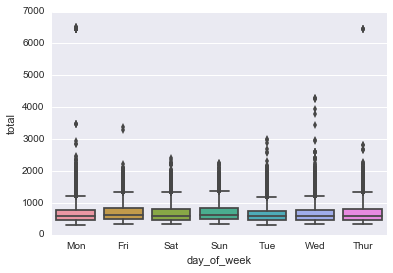

In [41]:
# The visualisation below shows what day of the week it is best to book a flight.
sns.boxplot(concat['day_of_week'], concat['total'])

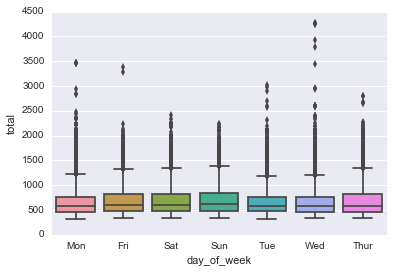

In [43]:
'''There are two outliers above $6,000. Below there is a visualisation on the distribution with flight prices
below $6,000.'''
concat2 = concat[concat['total'] < 6000]
sns.boxplot(concat2['day_of_week'], concat2['total'])

In [44]:
# Below one can see the mean price for a flight booked on a particular day of the week.
concat.groupby('day_of_week').mean()

,total
day_of_week,
Fri,695.859330
Mon,658.797686
Sat,683.030484
Sun,699.856178
Thur,678.577925
Tue,658.865848
Wed,659.666595


The flights are marginally cheaper on Mondays and Tuesdays. However, the difference between booking on these two days is relatively small.

Part 7: Price variety with the day of the week travelled on.

Below there is analysis on the different days of the week to depart and return and how that influences the price of the flight.

In [45]:
'''Columns needed: column with departure dates i.e. departure_odate. This is then converted into a day of the week.''' 

flights['departure_odate'] = pd.to_datetime(flights['departure_odate'])
flights['day_of_week_dep'] = flights['departure_odate'].dt.dayofweek
days = {0:'Mon',1:'Tue',2:'Wed',3:'Thur',4:'Fri',5:'Sat',6:'Sun'}
flights['day_of_week_dep'] = flights['day_of_week_dep'].apply(lambda x: days[x])
flights.head()

,messageid,tripindex,received,currency,total,tax,surcharge,source,merchant,majorcarrierid,...,triptimestamp,receiveddate,received_odate,departure_odate,return_ddate,los2,departure_dow,return_dow,includes_sns,day_of_week_dep
0,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,12,1382317607,USD,631.45,123.45,0.0,Sabre,TCY,US,...,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1,Fri
1,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,11,1382317607,USD,632.95,124.95,0.0,Sabre,TCY,US,...,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1,Fri
2,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,10,1382317607,USD,620.95,124.95,0.0,Sabre,TCY,B6,...,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1,Fri
3,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,9,1382317607,USD,632.95,124.95,0.0,Sabre,TCY,US,...,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1,Fri
4,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,8,1382317607,USD,565.95,124.95,0.0,Sabre,TCY,US,...,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1,Fri


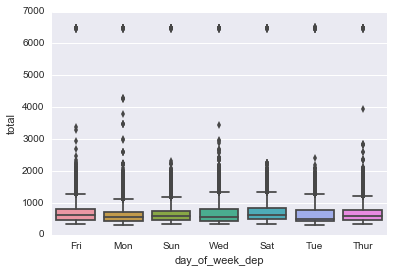

In [46]:
# Below is a visualisation of the price spread.

sns.boxplot(flights['day_of_week_dep'], flights['total'])

In [47]:
# The table is then grouped by the day of the week departure. Below are mean prices for each day of the week to depart.

grouped = flights.groupby('day_of_week_dep').mean()
groupeddf = pd.DataFrame(grouped['total'])
groupeddf.sort_values('total')

,total
day_of_week_dep,
Tue,626.971564
Mon,627.900513
Sun,651.500564
Thur,673.033312
Wed,677.623847
Fri,685.179145
Sat,707.917809


It is clear from above that the most expensive days to travel are Friday and Saturday which is somewhat expected - the travel for the weekend is usually more expensive. The cheapest days to fly from Boston to Cancun are Tuesday and Monday.

In [48]:
# The above steps are repeated for the return dates.

flights['return_ddate'] = pd.to_datetime(flights['return_ddate'])
flights['day_of_week_ret'] = flights['return_ddate'].dt.dayofweek
days = {0:'Mon',1:'Tue',2:'Wed',3:'Thur',4:'Fri',5:'Sat',6:'Sun'}
flights['day_of_week_ret'] = flights['day_of_week_ret'].apply(lambda x: days[x])
flights.head()

,messageid,tripindex,received,currency,total,tax,surcharge,source,merchant,majorcarrierid,...,receiveddate,received_odate,departure_odate,return_ddate,los2,departure_dow,return_dow,includes_sns,day_of_week_dep,day_of_week_ret
0,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,12,1382317607,USD,631.45,123.45,0.0,Sabre,TCY,US,...,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1,Fri,Sat
1,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,11,1382317607,USD,632.95,124.95,0.0,Sabre,TCY,US,...,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1,Fri,Sat
2,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,10,1382317607,USD,620.95,124.95,0.0,Sabre,TCY,B6,...,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1,Fri,Sat
3,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,9,1382317607,USD,632.95,124.95,0.0,Sabre,TCY,US,...,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1,Fri,Sat
4,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,8,1382317607,USD,565.95,124.95,0.0,Sabre,TCY,US,...,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1,Fri,Sat


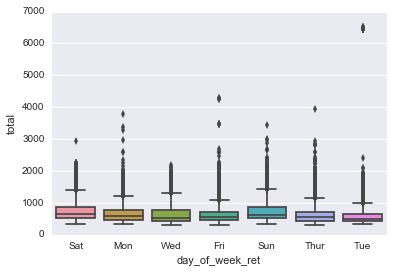

In [49]:
# A simple visualisation with box plots below - that shows the flight price spread.
sns.boxplot(flights['day_of_week_ret'], flights['total'])

In [50]:
# Similar to above, the table is grouped by the day of the week returned and mean prices are displayed.

grouped2 = flights.groupby('day_of_week_ret').mean()
groupeddf2 = pd.DataFrame(grouped2['total'])
groupeddf2.sort_values('total')

,total
day_of_week_ret,
Tue,587.906721
Fri,618.192966
Thur,635.998165
Mon,649.161847
Wed,651.201279
Sat,724.506405
Sun,735.317349


The cheapest day of the week to return from Cancun to Boston is Tuesday, with the second cheapest being Saturday. Most expensive days to return are Sunday, which is unsurprising considering it's the end of the weekend; and Saturday.

In [51]:
# The table is now grouped by both departure day of the week and return day of the week.

grouped3 = flights.groupby(['day_of_week_dep', 'day_of_week_ret']).mean()
grouped3df = pd.DataFrame(grouped3['total'])
grouped3df

total
day_of_week_dep day_of_week_ret            
Fri             Fri              648.313314
                Mon              671.862519
                Sat              783.742975
                Sun              703.458688
                Thur             669.397004
                Tue              612.570156
                Wed              754.278957
Mon             Fri              590.641378
                Mon              601.709979
                Sat              644.547527
                Sun              710.861894
                Thur             609.977553
                Tue              559.276708
                Wed              707.557244
Sat             Fri              664.001598
                Mon              678.835879
                Sat              731.627285
                Sun              686.599597
                Thur             638.343448
                Tue              583.994101
                Wed              689.127320
Sun             Fri              575.593330
                Mon              664.462996
                Sat              668.789391
                Sun              719.301648
                Thur             578.913307
                Tue              562.964301
                Wed              565.540041
Thur            Fri              640.614428
                Mon              669.787813
                Sat              702.324744
                Sun              734.055653
                Thur             672.078664
                Tue              630.974115
                Wed              669.317431
Tue             Fri              521.283394
                Mon              571.833854
                Sat              705.563544
                Sun              729.692373
                Thur             617.574370
                Tue              531.764000
                Wed              728.836896
Wed             Fri              575.008254
                Mon              683.745347
                Sat              798.385233
                Sun              834.310144
                Thur             585.582222
                Tue              632.317329
                Wed              551.575495

In [52]:
# The above table is not easily comprehensible to the user. Therefore, a pivot table is needed.

grouped3df.to_csv("grouped3df.csv")
grouped3df = pd.read_csv("grouped3df.csv")
grouped3df = grouped3df[['day_of_week_dep', 'day_of_week_ret', 'total']]
pivot_table = grouped3df.pivot('day_of_week_dep', 'day_of_week_ret', 'total')
pivot_table

day_of_week_ret,Fri,Mon,Sat,Sun,Thur,Tue,Wed
day_of_week_dep,,,,,,,
Fri,648.313314,671.862519,783.742975,703.458688,669.397004,612.570156,754.278957
Mon,590.641378,601.709979,644.547527,710.861894,609.977553,559.276708,707.557244
Sat,664.001598,678.835879,731.627285,686.599597,638.343448,583.994101,689.127320
Sun,575.593330,664.462996,668.789391,719.301648,578.913307,562.964301,565.540041
Thur,640.614428,669.787813,702.324744,734.055653,672.078664,630.974115,669.317431
Tue,521.283394,571.833854,705.563544,729.692373,617.574370,531.764000,728.836896
Wed,575.008254,683.745347,798.385233,834.310144,585.582222,632.317329,551.575495


In [53]:
# The columns are re-ordered so they start with Monday and finish with Sunday.

pivot_table = pivot_table[['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']]
pivot_table

day_of_week_ret,Mon,Tue,Wed,Thur,Fri,Sat,Sun
day_of_week_dep,,,,,,,
Fri,671.862519,612.570156,754.278957,669.397004,648.313314,783.742975,703.458688
Mon,601.709979,559.276708,707.557244,609.977553,590.641378,644.547527,710.861894
Sat,678.835879,583.994101,689.127320,638.343448,664.001598,731.627285,686.599597
Sun,664.462996,562.964301,565.540041,578.913307,575.593330,668.789391,719.301648
Thur,669.787813,630.974115,669.317431,672.078664,640.614428,702.324744,734.055653
Tue,571.833854,531.764000,728.836896,617.574370,521.283394,705.563544,729.692373
Wed,683.745347,632.317329,551.575495,585.582222,575.008254,798.385233,834.310144


In [54]:
# The same is done for the rows.

pivot_table = pivot_table.reindex(['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
pivot_table

day_of_week_ret,Mon,Tue,Wed,Thur,Fri,Sat,Sun
day_of_week_dep,,,,,,,
Mon,601.709979,559.276708,707.557244,609.977553,590.641378,644.547527,710.861894
Tue,571.833854,531.764000,728.836896,617.574370,521.283394,705.563544,729.692373
Wed,683.745347,632.317329,551.575495,585.582222,575.008254,798.385233,834.310144
Thur,669.787813,630.974115,669.317431,672.078664,640.614428,702.324744,734.055653
Fri,671.862519,612.570156,754.278957,669.397004,648.313314,783.742975,703.458688
Sat,678.835879,583.994101,689.127320,638.343448,664.001598,731.627285,686.599597
Sun,664.462996,562.964301,565.540041,578.913307,575.593330,668.789391,719.301648


In [ ]:
'''I can now see the different price combinations for different days of the week outbound and return.'''

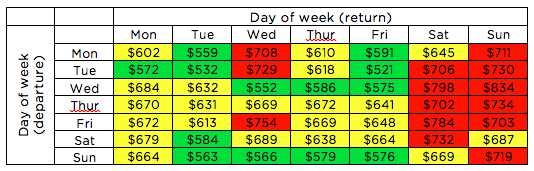

In [1]:
# Below is the display for customers with price ranges being colour-coded.
from IPython.display import Image
Image("dayofweek.png")